<h1><center>Guide Notebook for the 380CT Assignment on TSP</center></h1>

_Kamal Bentahar_

[https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance](https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance)

# Notation and definitions

Let $G$ be a complete weighted graph with $n$ vertices...

- **Complete**: the graph is undirected, has no self-loops, and each node is connected to all the other vertices.
- **Weighted**: the edges have a weight (a positive integer).
- **Cycle**: a path that visits every vertex once, and goes back to the start point.
- **Total cost of the cycle**: sum of the edge weights of the cycle.

# Definition of the problem

Given $G$ as above, the versions of the TSP are defined as follows:

* **Decisional TSP (D-TSP)**:
> Given a total cost $k$, decide if $G$ is has a cycle of length $\leq k$.

    **NP-complete**, because D-TSP $\in$ NP and D-TSP $\leq_p$ HAMCYCLE.
    
    * D-TSP $\in$ NP: once a cycle is given (a certificate) we can quickly evaluate the its cost in $O(n)$ time to verify it is equal to $k$.
    * D-TSP $\leq_p$ HAMCYCLE: Reduction from HAMCYCLE (Hoos and Stutzler, p.25).

* **Search TSP**:
> Given a total cost $k$, search for a cycle of length $\leq k$ in $G$.
> (If found then return it, otherwise say that there is no such cycle.)
    
* **Optimization TSP**:
> Given $G$, find a cycle of minimal total cost.

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search TSP**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979) and (Hoos and Stutzler, 2005).

# Testing methodology

* **Exact methods**:
    Average time for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average "quality" as $n$ increases.


## Random instances sampling strategy

General TSP instances will be generated by creating symmetric adjacency matrices uniformly at random.

# Code

First start by importing relevant libraries.

In [0]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import exp, log
from time      import time
import matplotlib.pyplot as plt
import copy

## Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

Without loss of generality, we can consider $0$ to be the start and end point of cycles.

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    avg_dist = 0
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            avg_dist += v
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix, avg_dist/n

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        # a = cycle[i]
        # b = cycle[(i+1)%n]
        c += G[cycle[i]][cycle[i-1]]
    return c

### Example

In [0]:
G, avg_dist = random_symmetric_graph(5)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  30  57  97  28
 1 |   30   ∞   9  44  83
 2 |   57   9   ∞  42  23
 3 |   97  44  42   ∞  57
 4 |   28  83  23  57   ∞



# Solution methods

## Exact methods -- Exhaustive search

The idea is to:
- Consider vertex $0$ as the start and end point.
- Iterate over all permutations of the vertices $\{1,2,\ldots, n-1\}$.
    -  Calculate cost of each permutation and keep track of minimum cost permutation.
- Return the cycle with minimum cost.

More formally, the pseudo-code is as follows:

**Input**: $G$.

**Output**: a cycle in $G$ of shortest cost.

1. $bestcycle\gets \emptyset$
2. $bestcost\gets \infty$
3. **for all** possible cycles $p$ in $G$ (starting and ending at $0$) **do**
4. $\quad$ $c\gets$ cost of $p$
2. $\quad$ **if** $c<bestcost$ **then**
3. $\qquad$ $bestcycle\gets p$
3. $\qquad$ $bestcost\gets c$
4. $\quad$ **end if**
5. **end for**
6. **return** $bestcycle, bestcost$

There are $(n-1)!$ possible cycles, and each computation of a cycle's cost costs $O(n)$. So this algorithm costs $$O((n-1)!\cdot n)=O(n!).$$

In [0]:
def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

## Testing

In [0]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G, avg_dist = random_symmetric_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.0074117183685302734
9	0.0628976821899414
10	0.5894761085510254
11	6.223202705383301


Let us plot this data to see it visually.

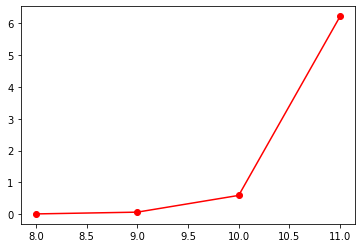

In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

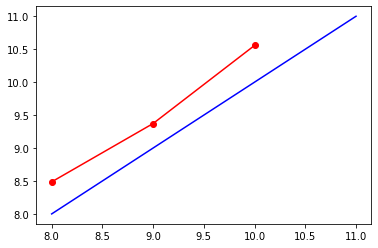

In [0]:
pnts_ratios = [pnts_t[i]/pnts_t[i-1] for i in range(1,len(pnts_n))]
plt.plot(pnts_n[:-1], pnts_ratios, 'ro-')
plt.plot(pnts_n,pnts_n,'b-') # theoretical ratios
plt.show()

### Discussion

* Exhaustive search exhibits combinatorial running time $O(n!)$:
* So it is only useful/possible when $n$ is small, up to about 13 on the current machine if it needs to finish within an hour.

# Approximation

## Greedy search

##### Nearest neigbours

In [0]:
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))


### Example

In [0]:
G, avg_dist = random_symmetric_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞  22  18  29
 1 |   22   ∞   3  49
 2 |   18   3   ∞  38
 3 |   29  49  38   ∞



([0, 2, 1, 3], 99)

### Test

In [0]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<10: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_avgs = 0

    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        t0 = time()
        cycle, c = greedy_nearest_neighbours(G)
        t1 = time()

        sum_of_avgs += (avg_dist/2)*n
        sum_of_distances += c
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    q2 = sum_of_distances/sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}\t{q2}" )
    n *= 2

10	0.010467290878295898	0.51832	0.22600308709263894
20	0.03234672546386719	0.31677	0.06643073970965256
40	0.11607956886291504	0.203305	0.020653688924287247
80	0.44347405433654785	0.12048	0.006036712183975919
160	1.701803207397461	0.07553	0.0018802804021361647
320	6.803750038146973	0.049366875	0.0006130654209424442
640	27.88492488861084	0.034676250000000006	0.00021493547683531125


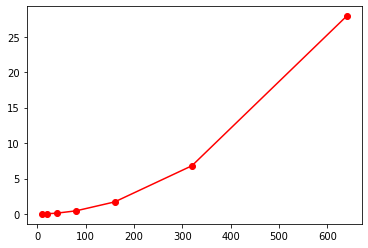

In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

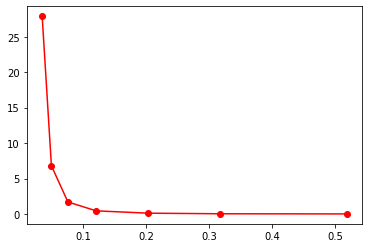

In [0]:
plt.plot(pnts_q, pnts_t, 'ro-')
plt.show()

## Metaheuristics

## 1. Iterative Improvement

**Input**: $G$, $cycle$, $best Distance$

**Output**: a cycle in $G$ of shortest cost, $best Distance$

1. $Pick the first neighbour with a lower cost S$
2. **while S is not a local optimum do**
3. $\quad$ choose a neighbour $S'$ of $S$ such $f(s')<f(s)$
4. $\quad$ $S\gets S'$
5. **end while**
6. **return** $S$



In [0]:
def twoOptSwap(cycle, i, k):
    new_cycle = cycle[:i]
    new_cycle += cycle[i:k+1][::-1]
    new_cycle += cycle[k+1:]
    return new_cycle

def iterative_improvement(G, cycle, best_distance):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    # cycle, best_distance = greedy_nearest_neighbours(H) # initial sol
    
    improved = True
    while improved:
        improved = False
        # calculate total dist for existing route 
        best_distance = cost(H, cycle)

        for i in range(0, n-2):
            improved = False
        
            for k in range(i+1, n-1):
                # new_cycle = twoOptSwap(cycle, i, k)
                new_cycle = cycle[:i] + cycle[i:k+1][::-1] + cycle[k+1:]
                new_distance = cost(H, new_cycle)
                
                if new_distance < best_distance:
                    cycle = new_cycle
                    best_distance = new_distance
                    improved = True
                    break
            
            if improved:
                break
                    
                
    return (cycle, best_distance)
    

In [0]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

iterative_improvement(G, cycle, best_distance)

        0   1   2   3   4
    ---------------------
 0 |    ∞   2  61  95  58
 1 |    2   ∞  44  87  97
 2 |   61  44   ∞  46  20
 3 |   95  87  46   ∞  12
 4 |   58  97  20  12   ∞



([2, 1, 0, 4, 3], 162)

In [0]:
MAX_REPETITIONS = 10

pnts_n = []
pnts_t = []
pnts_q = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while t < 15: # in seconds; if it takes too long then stop testing
    t = 0; t2 = 0
    # expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_distances = 0; sum_of_inits = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        cycle, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        sum_of_distances += c
        sum_of_avgs += (avg_dist/2)*n
        t += t1-t0
        t2 += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    qi = sum_of_distances / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t: .2f}\t{t2: .2f}\t{q: .5f}\t{qi: .5f}" )
    n += 50

sz	iter	NN	Q1
50	 0.39	 0.02	 0.01394	 0.00999
100	 3.43	 0.07	 0.00400	 0.00279
150	 14.73	 0.15	 0.00212	 0.00140
200	 32.71	 0.27	 0.00125	 0.00089


In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

## 2. Simulated Annealing

**Input**: $G$, $cycle$, $best Distance$

**Output**: a cycle in $G$ of shortest cost, $best Distance$

1. $ Determine initial candidate solution $S$ $
2. $ Set initial temperature $T$ according to annealing schedule$
3. **while termination condition not satisfied do**
4. $\quad$ Randomly choose a neighbour $s'$ of $s$ after $K$ optimisations
5. $\quad$ **if** $s'$ satisfies probabilistic acceptance criterion (cost smaller than previous)  **then**
6. $\qquad$ $s \gets s'$
7. $\quad$ **end if**
8. $\quad$ update $T$ according to annealing schedule$
9. **end while**

10. **return** $cycle, best distance$


In [0]:
# SA constants, used for tuning the algo

start_temperature = 1e2
stop_temperature = 5.
MAX_CYCLES = 10
UNCHANGED_FOR_MAX = 50

# temperature scheduling
temp_dropoff = exp(log(stop_temperature / start_temperature) / (MAX_CYCLES-1))

In [0]:
def generate_cycle(G):
    N = len(G)
    taken = [False] * N
    cycle = [0] * N

    for i in range(N-1):
        candidate_idx = randint(0, N-1)
        while taken[candidate_idx]:
            candidate_idx = randint(0, N-1)
        
        cycle[i] = candidate_idx
        taken[candidate_idx] = True

        if i == N-2:
            candidate_idx = 0
            while taken[candidate_idx]:
                candidate_idx += 1

            cycle[i+1] = candidate_idx

    return (cycle, cost(G, cycle))

In [0]:
def randomize(cycle, temperature):
    n = len(cycle) - 1
    for _ in range(int(temperature)):
        idx1 = randint(0, n)
        nxt1 = (idx1+1) % (n+1)
        idx2 = randint(0, n)
        nxt2 = (idx2+1) % (n+1)

        distance = G[cycle[idx1]][cycle[nxt1]] \
                 + G[cycle[idx2]][cycle[nxt2]] \
                 - G[cycle[idx1]][cycle[idx2]] \
                 - G[cycle[nxt1]][cycle[nxt2]]
        if distance > 0:
            # sort indices in ascending order
            if idx2 < idx1:
                idx1, idx2 = idx2, idx1
                nxt1, nxt2 = nxt2, nxt1
            cycle = cycle[:nxt1] + cycle[nxt1:idx2][::-1] + cycle[idx2:]

    return cycle

In [0]:
def sa_iteration(G, cycle, best_distance):
    # set initial temp
    temperature = start_temperature
    
    for _ in range(MAX_CYCLES):
        new_cycle = randomize(cycle, temperature)
        new_distance = cost(G, new_cycle)
        
        if new_distance < best_distance:
            cycle = new_cycle
            best_distance = new_distance

        temperature *= temp_dropoff

    return (cycle, best_distance)

In [0]:
def simulated_annealing(G, cycle = None, best_distance = None):
    cycle = cycle or list(range(len(G)))
    best_distance = best_distance or cost(G, cycle)

    distance = best_distance - 1

    # iterate until a local minimum is found
    unchanged_for = 0
    while unchanged_for < UNCHANGED_FOR_MAX:
        if best_distance == distance:
            unchanged_for += 1
        else:
            distance = best_distance
            unchanged_for = 0
            cycle, best_distance = sa_iteration(G, cycle, distance)
    
    return (cycle, best_distance)

In [0]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

simulated_annealing(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  64  86  98   5
 1 |   64   ∞  36  59   5
 2 |   86  36   ∞  29  68
 3 |   98  59  29   ∞  55
 4 |    5   5  68  55   ∞



([0, 1, 2, 3, 4], 189)

# Conclusion

In [0]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []; pnts_t_sa = []
pnts_q = []; pnts_q_sa = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while t < 10: # in seconds; if it takes too long then stop testing
    t = t_iter = t_sa = 0
    sum_of_distances = sum_of_inits = sum_of_sa = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        # _, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        _, sa = simulated_annealing(G)
        t2 = time()
        sum_of_distances += c
        sum_of_sa += sa
        sum_of_avgs += (avg_dist/2)*n
        t_sa += t2 - t1
        # t_iter += t1-t0
        t += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    # qi = sum_of_distances / sum_of_avgs
    q_sa = sum_of_sa / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_t_sa.append( t_sa )
    pnts_q.append( q )
    pnts_q_sa.append( q_sa )
    # print( f"{n}\t{t: .2f}\t{t_iter: .2f}\t{t_sa: .2f}\t{q: .5f}\t{qi: .5f}\t{q_sa: .5f}" )
    print( f"{n}\t{t: .2f}\t{t_sa: .2f}\t{q: .5f}\t{q_sa: .5f}" )
    n += 50

sz	iter	NN	Q1
50	 0.19	 0.59	 0.01377	 0.04741
100	 0.69	 0.92	 0.00415	 0.02449
150	 1.55	 1.31	 0.00214	 0.01669
200	 2.76	 1.59	 0.00130	 0.01279
250	 4.29	 1.88	 0.00090	 0.01046
300	 6.20	 2.48	 0.00068	 0.00882
350	 8.62	 3.03	 0.00053	 0.00753
400	 11.33	 3.27	 0.00043	 0.00671


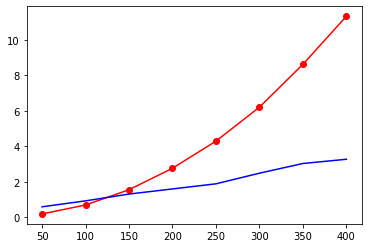

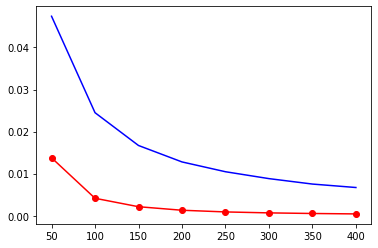

In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.plot(pnts_n, pnts_t_sa, 'b-')
plt.show()
plt.plot(pnts_n, pnts_q, 'ro-')
plt.plot(pnts_n, pnts_q_sa, 'b-')
plt.show()

**Clear, brief and precise practical recommendations on
which algorithms to use when, based on your computational experiments.**

# References

* Garey, S. and Johnson, D. (1979)
**Computers and Intractability: A Guide to the Theory of NP-Completeness.**
Freeman.

* Hoos, H. and Stutzler, T. (2005)
**Stochastic Local Search: Foundations and Applications.**
Morgan Kaufmann.

* Sipser, M. (2013).
**Introduction to the theory of computation**
(3rd international ed.). Cengage Learning.